Markov state model for F10 in 150mM ZnCl2
=====


In [1]:
import matplotlib.pylab as plt
import numpy as np
import math
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
import pyemma.coordinates as coor

/Users/melvrl13/anaconda/lib/python2.7/site-packages/pyEMMA-2.0.1-py2.7-macosx-10.5-x86_64.egg/pyemma/coordinates/util/stat.py:31: DeprecationWarning: Call to deprecated function hist. Called from pyemma.coordinates.util.stat line 31. Please use pyemma.coordinates.histogram()
  def hist(transform, dimensions, nbins):


In [3]:
trajfile = '/Volumes/RyanMdata-1/F10/ZnCl2_150mM/cat16/F10_150mMZnCl2.dcd'
topfile = '/Volumes/RyanMdata-1/F10/F10.pdb'

Now we decide which coordinates we would like to use in the further analysis. Since this trajectory is already RMSD-aligned we can simply use the Cartesian coordinates, here Ca-coordinates:

In [4]:
feat = coor.featurizer(topfile)
# just use all xyz-coordinates
feat.add_all()

We can ask the featurizer to tell describe the coordinates used - so we can later remember what we did. The return is a list of strings and we will just print the first few labels here:

In [5]:
feat.describe()[:10]

['ATOM:U 0 FU 0 x',
 'ATOM:U 0 FU 0 y',
 'ATOM:U 0 FU 0 z',
 'ATOM:U 0 H5T 1 x',
 'ATOM:U 0 H5T 1 y',
 'ATOM:U 0 H5T 1 z',
 "ATOM:U 0 O5' 2 x",
 "ATOM:U 0 O5' 2 y",
 "ATOM:U 0 O5' 2 z",
 "ATOM:U 0 C5' 3 x"]

Next we want to load the coordinates from disc. Often, coordinates will not fit into memory, so we'll just create a loader by specifying the source files as follows:

In [6]:
inp = coor.source(trajfile, feat)
print 'trajectory length = ',inp.trajectory_length(0)
print 'number of dimension = ',inp.dimension()

trajectory length =  16000
number of dimension =  867



time-lagged independent component analysis (TICA)
----------

It turns out that a really good way to do that if you are interesting in the slow kinetics of the molecule - e.g. for constructing a Markov model, is to use the time-lagged independent component analysis (TICA) [2]. Amongst linear methods, TICA is optimal in its ability to approximate the relevant slow coordinates / reaction coordinates from MD simulation [3], and therefore it's ideal to construct Markov models. Probably you are more familiar with the principal component analysis (PCA), but we will come back to that later...

In [7]:
lag=1
tica_obj = coor.tica(inp, dim=2)
# here we get the data that has been projected onto the first 2 IC's. It's a list, because we could generally
# have a list of trajectories, so we just get the first element.
Y = tica_obj.get_output()[0]
print 'Projected data shape = ',Y.shape

getting output of TICA: 100% (160/160) [###########################] eta 00:00 |Projected data shape =  (16000, 2)


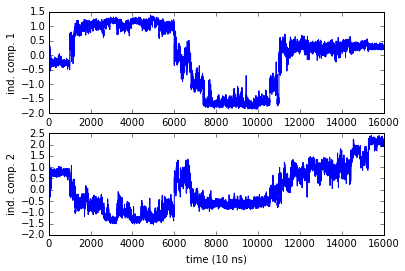

In [8]:
subplot2grid((2,1),(0,0))
plot(Y[:,0])
ylabel('ind. comp. 1')
subplot2grid((2,1),(1,0))
plot(Y[:,1])
ylabel('ind. comp. 2')
xlabel('time (10 ns)')

In [9]:
print 'Mean values: ',np.mean(Y, axis=0)
print 'Variances:   ',np.var(Y, axis=0)

Mean values:  [ -1.28289685e-07  -4.53911724e-07]
Variances:    [ 0.97828692  0.95478374]


In [10]:
print -lag/np.log(tica_obj.eigenvalues[:5])

[ 91.36774703  43.28434339  32.1355737   14.07639832  10.70577075]


We will see more timescales later when we estimate a Markov model, and there will be some differences. For now you should treat these numbers as a rough guess of your molecule's timescales, and we will see later that this guess is actually a bit too fast. The timescales are relative to the 0.01 ns saving interval, so we have 260 nanoseconds, 130ns, ..

Now we histogram this data and compute the apparent free energy landscape

/Users/melvrl13/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


<matplotlib.contour.QuadContourSet instance at 0x10e3f14d0>

/Users/melvrl13/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


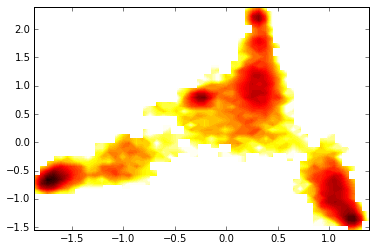

In [11]:
# histogram data
z,x,y = np.histogram2d(Y[:,0],Y[:,1], bins=50)
# compute free energies
F = -np.log(z)
# contour plot
extent = [x[0], x[-1], y[0], y[-1]]
contourf(F.T, 50, cmap=plt.cm.hot, extent=extent)

So we nicely see that there are a couple of different energy minima are present and clearly separated in the TICA projection.

Clustering the data
------

we use k-means clustering and get the discrete trajectories. PyEmma documentation suggests using sqrt(# frames) as number of clusters.

In [12]:
print 'trajectory length = ',inp.trajectory_length(0)
sqrt_frames = int(math.sqrt(inp.trajectory_length(0)))
print 'clusters = ',sqrt_frames

trajectory length =  16000
clusters =  126


In [13]:
cl = coor.cluster_kmeans(data=Y, k=sqrt_frames, stride=1)
# for later use we save the discrete trajectories and cluster center coordinates:
dtrajs = cl.dtrajs
cc_x = cl.clustercenters[:,0]
cc_y = cl.clustercenters[:,1]

getting output of KmeansClustering: 100% (4/4) [###################] eta 00:01 -

where are the clusters?

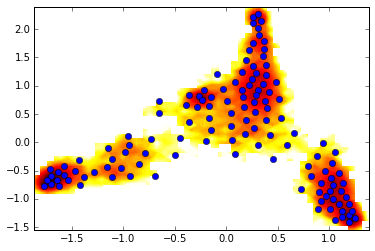

In [14]:
contourf(F.T, 50, cmap=plt.cm.hot, extent=extent)
plot(cc_x,cc_y, linewidth=0, marker='o')

For our purpose, the main result from the clustering algorithm are discrete trajectories:

In [15]:
cl.dtrajs

[array([ 91, 124,   8, ...,  72,  72,  26], dtype=int32)]

This is a list of integer-arrays, one for each trajectory used (here only one). The integer-array contains one number between 0 and 99 (because we have used 100 cluster centers) for each MD trajectory frame.

MSM estimation
---------


In [16]:
import pyemma.msm as msm
import pyemma.plots as mpl

The quality and the practical usefulness of a Markov model depend on two main parameters:

1. The state-space discretization, i.e. which steps we have conducted before (choice of coordinates, projection method, clustering method)
2. The lag time, i.e. at which time do we count transitions.

The first choice is quite complex and there are some ways to deal with this complexity and the reduce the number of choices, although we won't discuss them in detail here. The second parameter is extremely important, and we should scan it in order to make a good selection. So Let us compute the so-called implied timescales, or relaxation timescales of the Markov model at different lag times:

In [17]:
lags = [1,2,5,10,20,50,100,200]
its = msm.its(dtrajs, lags=lags)

estimating MaximumLikelihoodMSM: 100% (8/8) [######################] eta 00:01 \

What this function does is to estimate a Markov model at each of the given lag times $\tau$ (that are multiples of our saving step, i.e. multiples of 10 ns), compute the eigenvalues of each transition matrix, $\lambda_i(\tau)$, and then compute the relaxation timescales by:
   $$ t_i = \frac{-\tau}{\ln | \lambda_i(\tau) |}$$
The its object will mainly give us these estimated timescales. We can simply push the result to a standard plotting function:

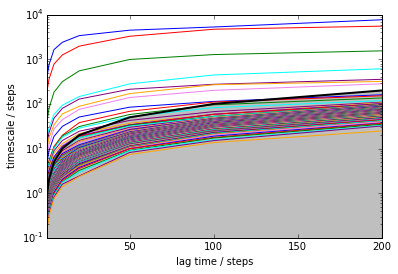

In [18]:
mpl.plot_implied_timescales(its)

It has been shown [4] that these timescales should be independent of the lag time. You can see that for short lag times they are not, but after about 100 steps (1 nanosecond), they are pretty constant. The faster timescales still increase. Part of this is normal and due to numerical issues. Part of this is because our state space discretization is rather naive - we cannot hope to capture a lot of relaxation processes when using only two dimensions.

In a nutshell: longer timescale is better, at least as long you stay away from the grey area. The grey area is defined by lag > timescale, and in this area we cannot make a reliable estimate because the process under investigation has already decayed. Everything within or close to the grey area is distorted.

MSM
---
So finally we can estimate a Markov model. In fact we have already estimated a several Markov models (for different lag times above), but now we construct an msm object which will give us access to a wide variety of interesting quantities. All we need to put in are the discrete trajectories obtained from the clustering and the lag time:

In [19]:
M = msm.estimate_markov_model(dtrajs, 50)

The Markov model will be constructed on the largest connected set of states. That could mean that we exclude some states from the analysis. Let us verify that this is not the case here:

In [20]:
print 'fraction of states used = ', M.active_state_fraction
print 'fraction of counts used = ', M.active_count_fraction

fraction of states used =  1.0
fraction of counts used =  1.0


Spectral analysis
-----------

Let us have a closer look at the timescales that were already seen in the its plot:

(-0.5, 10.5)

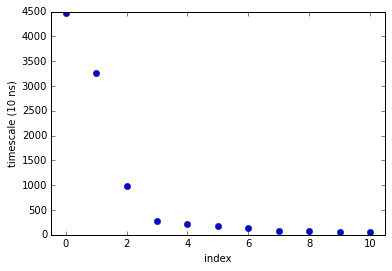

In [21]:
plot(M.timescales(),linewidth=0,marker='o')
xlabel('index'); ylabel('timescale (10 ns)'); xlim(-0.5,10.5)

We can also look at that data by taking the ratios of subsequent timescales. This shows us how big the gap of timescales (or rates) are.

(-0.5, 10.5)

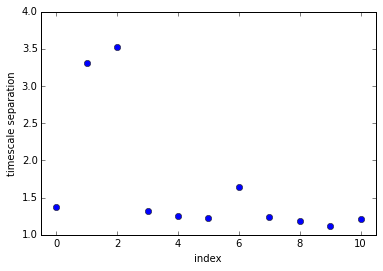

In [22]:
plot(M.timescales()[:-1]/M.timescales()[1:], linewidth=0,marker='o')
xlabel('index'); ylabel('timescale separation'); xlim(-0.5,10.5)

It can be seen that there is a large timescale separation between the third and fourth relaxation timescale. That means that if we are interested in coarse-graining our dynamics, retaining two relaxation timescales, or three metastable states, is a good choice.

Now let us look at the third (slowest) right eigenvector

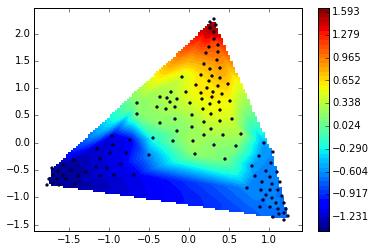

In [23]:
r2 = M.eigenvectors_right()[:,2]
ax = mpl.scatter_contour(cc_x, cc_y, r2)

Clearly, the slowest process (about 40 microseconds) involves a change along the first TICA component. This is great news for TICA, because it means that even before computing a Markov model we have done a very good job in finding a slow order parameter. However, remember that this process has occurred only once in the trajectory, so unfortunatly our data is quite poor with respect to quantifying it.

Let us then look at the second (next-slowest) right eigenvector

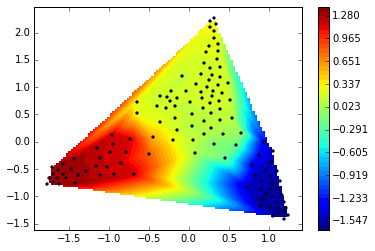

In [24]:
r3 = M.eigenvectors_right()[:,1]
mpl.scatter_contour(cc_x, cc_y, r3)

This process is between 15 and 20 microseconds and clearly transitions between the two prominent minima on the left.

Now we want to coarse-grain our system to get a simpler description. The PCCA method [5] uses the eigenvectors in order to perform a spectral clustering. This clustering is fuzzy, i.e. each of our k-means clusters is linked to one of the metastable states with a certain probability or membership. Here we plot the Bayesian inverse, i.e. the probability to be in a small state given that we are in a metastable state. We choose three metastable states, so we have three distributions:

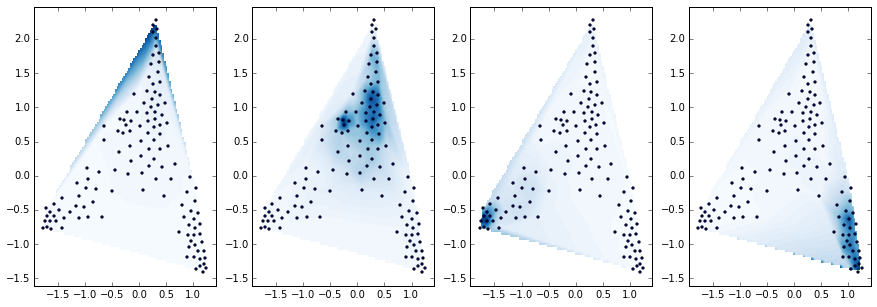

In [25]:
M.pcca(4)
pcca_dist = M.metastable_distributions
f, (ax1,ax2,ax3,ax4) = subplots(ncols=4)
f.set_size_inches(15,5)
cmap=plt.cm.Blues
mpl.scatter_contour(cc_x, cc_y, pcca_dist[0], fig=f, ax=ax1, colorbar=False, cmap=cmap)
mpl.scatter_contour(cc_x, cc_y, pcca_dist[1], fig=f, ax=ax2, colorbar=False, cmap=cmap)
mpl.scatter_contour(cc_x, cc_y, pcca_dist[2], fig=f, ax=ax3, colorbar=False, cmap=cmap)
mpl.scatter_contour(cc_x, cc_y, pcca_dist[3], fig=f, ax=ax4, colorbar=False, cmap=cmap)

Representative Structures
--------

Now we want to see some structures. Let us use the PCCA distributions in order to select structures.
We will get 100 frame indexes for each of the three distributions

In [26]:
pcca_samples = M.sample_by_state(1,replace=False)
pcca_samples.tofile('./tica/pcca_samples.txt',sep=',')

and now we save them.

In [27]:
coor.save_traj(inp, pcca_samples[0], './tica/pcca1_1samples.pdb')
coor.save_traj(inp, pcca_samples[1], './tica/pcca2_1samples.pdb')
coor.save_traj(inp, pcca_samples[2], './tica/pcca3_1samples.pdb')
coor.save_traj(inp, pcca_samples[3], './tica/pcca4_1samples.pdb')

Now let's show where these are on our Tica plot.
Red is 1; blue is 2; green is 3.

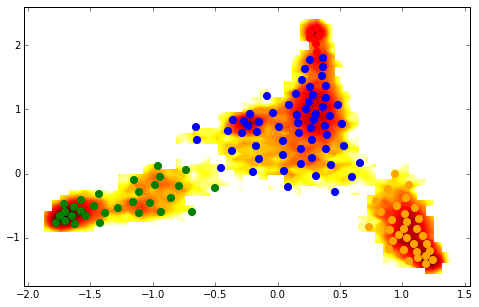

In [28]:
figure(figsize=(8,5))
pcca_sets = M.metastable_sets
contourf(F.T, 50, cmap=plt.cm.hot, extent=extent)
scatter(cl.clustercenters[pcca_sets[0],0], cl.clustercenters[pcca_sets[0],1], color='red', s=50)
scatter(cl.clustercenters[pcca_sets[1],0], cl.clustercenters[pcca_sets[1],1], color='blue', s=50)
scatter(cl.clustercenters[pcca_sets[2],0], cl.clustercenters[pcca_sets[2],1], color='green', s=50)
scatter(cl.clustercenters[pcca_sets[3],0], cl.clustercenters[pcca_sets[3],1], color='orange', s=50)

Now let's look at hiddem markov models.

In [29]:
import pyemma.plots as mplt
# Coarse grain MSM
hmm = M.coarse_grain(4)
# Now look for the stationary distribution
hmm.stationary_distribution

array([  9.98909966e-01,   4.12313310e-04,   3.16583109e-04,
         3.61138019e-04])

What is the hidden markov model's transition matrix?
hmm.transition_matrix

In [30]:
hmm.transition_matrix

array([[  9.99996215e-01,   3.78544405e-06,   2.70068166e-30,
          4.48355742e-24],
       [  9.17098162e-03,   9.72480857e-01,   9.17605395e-03,
          9.17210785e-03],
       [  8.52142057e-27,   1.19507613e-02,   9.88049239e-01,
          3.85818175e-19],
       [  1.24015472e-20,   1.04718472e-02,   3.38218385e-19,
          9.89528153e-01]])

So let’s visualize the HMM in a network plot. The numbers shown are transition probabilities given the model lag time (50 ns). It is seen that we have a star structure with one highly probable state as a hub, The two lowest likelihood states pass through state 1 in order to get to state 0.

First, we need to define a method for saving the planar graph we're generating.

In [31]:
def save_figure(name):
    # change these if wanted
    do_save = True
    fig_dir = './tica/'
    if do_save:
        savefig(fig_dir + name, bbox_inches='tight')

Now we'll make the graph and save it.

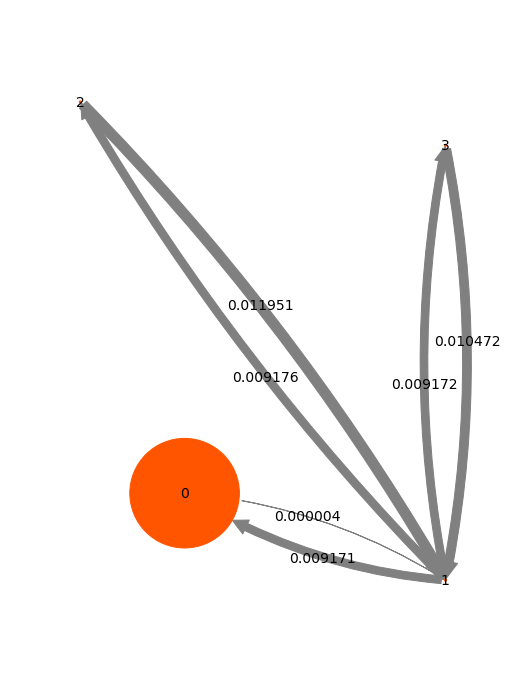

In [32]:
pos=np.array([[-3, -4], [0, -5], [-4.2, 0.5], [0, 0]])
mplt.plot_markov_model(hmm, pos=pos, arrow_label_format='%.6f')
gca().set_frame_on(False)
save_figure('network.png')

References
------

1. Shaw DE, Maragakis P, Lindorff-Larsen K, Piana S, Dror RO, Eastwood MP, Bank JA, Jumper JM, Salmon JK, Shan Y,
Wriggers W: Atomic-level characterization of the structural dynamics of proteins.
*Science* **330**:341-346 (2010). doi: 10.1126/science.1187409.
2. Molgedey, L. and H. G. Schuster, Phys. Rev. Lett. 72, 3634 (1994).
3. Pérez-Hernández, G. and Paul, F. and Giogino, T. and de Fabritiis, G. and Noé, F. Identification of slow molecular order parameters for Markov model construction. *J. Chem. Phys.* **139**:015102 (2013)
4. Swope WC, Pitera JW and Suits F. Describing protein folding kinetics by molecular dynamics simulations: 1. Theory. 
*J. Phys. Chem. B* **108**:6571-6581 (2004)
5. Röblitz S. and M. Weber: Fuzzy spectral clustering by PCCA+: application to Markov state models and data classification. Adv. Data. Anal. Classif. DOI 10.1007/s11634-013-0134-6 (2013) 
6. Noé F, Doose S, Daidone I, Löllmann M, Chodera JD, Sauer M, Smith JC. Dynamical fingerprints for probing individual relaxation processes in biomolecular dynamics with simulations and kinetic experiments. *Proc. Natl. Acad. Sci. USA*, **108**: 4822-4827 (2011)
7. Metzner P, Schütte C, Vanden-Eijnden, E. Transition Path Theory for Markov Jump Processes. *Multiscale Model. Simul.* **7**. 1192--1219 (2009)
8. Noé F, Schütte C, Vanden-Eijnden E, Reich L and Weikl T. Constructing the Full Ensemble of Folding Pathways from Short Off-Equilibrium Simulations. *Proc. Natl. Acad. Sci. USA*, **106**:19011-19016 (2009)